In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from eggman.grid import luminosity, log_surface_gravity, calculate_eep
from eggman.grid.defaults import MASS, YINI, ZINI, AGE, TEFF, RAD, DNUF, AMLT

import tensorflow as tf

print(f"Using TensorFlow {tf.__version__}")

DIR = "/mnt/data-storage/stellar-emulator/train"
FILENAME = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"

RSTATE = 0
EEP = "EEP"
PHASE = "phase"
LUM = "L"
GRAV = "g"
LOG = "log"
SEP = "_"

UNITS = 128
LAYERS = 7
ACTIV = "elu"
LRATE = 1e-3
BETA1 = 0.9
BETA2 = 0.999
LOSS = "mean_squared_error"
BATCH_SIZE = 65536   # 65536 corresponds to about 1000 epochs in 10 mins
MAX_EPOCHS = 100000  # about 17 hours
SHUFFLE = True
# PATIENCE = 100
# MIN_DELTA = 1e-8  # min change after PATIENCE epochs

print(f"Loading grid data from '{FILENAME}'.")
tracks = pd.read_hdf(FILENAME, "tracks")
stars = pd.read_hdf(FILENAME, "stars")
data = tracks.join(stars).dropna().reset_index()
data.head()

2023-11-22 22:50:57.381060: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 22:50:57.381091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 22:50:57.381122: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 22:50:57.386744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 22:50:58.059664: W tensorflow/compiler/

Using TensorFlow 2.14.0
Loading grid data from '/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5'.


,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,Teff,center_h1,log_LHe,log_Lnuc,Dnu_freq_o,eps_o,delta_Pg
0,7000,1,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.220454e+07,0.893151,6382.509287,0.718192,-45.291905,0.078416,148.565794,1.129515,0.0
1,7000,2,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.300916e+07,0.891027,6377.312552,0.718122,-45.308912,0.077135,149.148739,1.131800,0.0
2,7000,3,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.397470e+07,0.890320,6373.785487,0.718037,-45.328570,0.075916,149.362908,1.132830,0.0
3,7000,4,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.019433e+07,0.893682,6371.412400,0.717474,-45.392646,0.075178,148.552167,1.130613,0.0
4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,6371.453759,0.717253,-45.402736,0.075810,148.331713,1.129892,0.0


In [3]:
data["kron"] = data["star_age"] * data["star_mass"]**3.2
data["log_kron"] = np.log10(data["kron"])

In [6]:
print("Preprocessing data.")
# Create log10 quantities
for key in [ZINI, AGE, TEFF, RAD, DNUF, MASS]:
    data[SEP.join([LOG, key])] = np.log10(data[key])

data[SEP.join([LOG, GRAV])] = log_surface_gravity(data)
data[SEP.join([LOG, LUM])] = np.log10(luminosity(data))

# Drop bad tracks
with open("../notebook/central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

data = data.drop(index=data[data.track.isin(bad)].index)

print("Calculating EEP.")
# Add EEP and drop pre-MS and post log_g cutoff
keys = [SEP.join([LOG, key]) for key in [AGE, TEFF, LUM]]
primary, secondary = calculate_eep(data, keys)
data[PHASE] = primary
data[EEP] = secondary

data = data.drop(index=data[data.phase == -1].index)

print("Preparing train and test dataset.")
train = data.sample(frac=0.8, random_state=RSTATE)
test = data.drop(index=train.index)

# Separate features and labels
# features = [EEP, MASS, YINI, SEP.join([LOG, ZINI]), AMLT]
# labels = [SEP.join([LOG, key]) for key in [AGE, TEFF, RAD, DNUF]]
features = ["log_star_age", "log_star_mass", "log_kron", "Yinit", "log_Zinit", "amlt"]
labels = [SEP.join([LOG, key]) for key in [TEFF, RAD, DNUF]]
num_features, num_labels = len(features), len(labels)

train_features = train[features].astype(np.float32).copy()
test_features = test[features].astype(np.float32).copy()

train_labels = train[labels].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

Preprocessing data.
Calculating EEP.
Preparing train and test dataset.


In [12]:
DIR = '/mnt/data-storage/stellar-emulator/tuning'

In [13]:
project_name = "20231122-172018/trail_16"
model = tf.keras.models.load_model(os.path.join(DIR, project_name, "best_model.tf"))

OSError: No file or directory found at /mnt/data-storage/stellar-emulator/tuning/20231122-172018/best_model.tf

In [4]:
with tf.device('/gpu:1'):
    test_pred = pd.DataFrame(model(test_features), columns=test_labels.columns, index=test_labels.index)
test_pred.head()

2023-06-29 09:37:23.723806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
7,7.757585,3.803306,-0.044219,2.167684
22,8.886614,3.806324,-0.031188,2.145130
24,8.941278,3.806291,-0.029218,2.142053
25,8.967688,3.806305,-0.028057,2.140313
30,9.075359,3.807281,-0.023303,2.133050


In [35]:
log_error = test_pred - test_labels
ln_error = log_error / np.log10(np.e)
error = 10**test_pred - 10**test_labels

In [6]:
num_samples = 10000
sample = test_labels.sample(num_samples)

Text(0, 0.5, 'log(L/Lsun)')

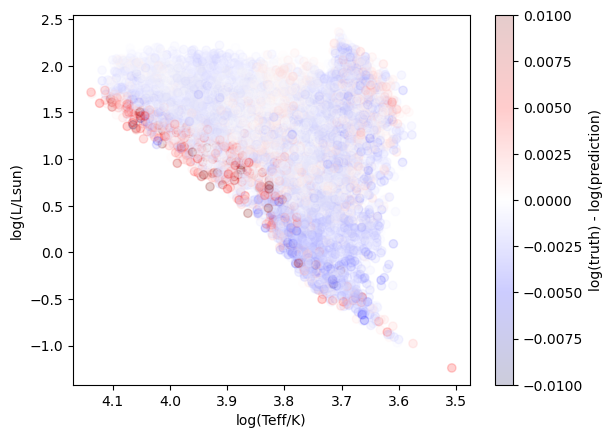

In [7]:
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.01, vmax=0.01)
fig.colorbar(s, label="log(truth) - log(prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

In [22]:
from matplotlib.colors import PowerNorm

In [59]:
sample[key].max()

11.0418119430542

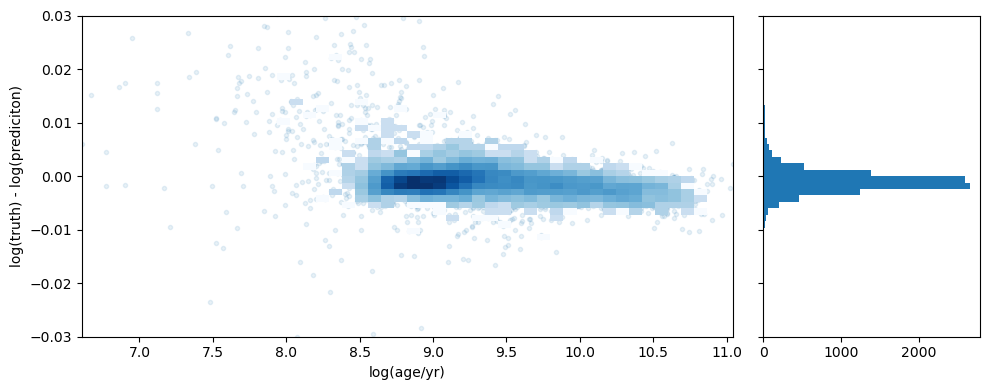

In [65]:
key = "log_star_age"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [-0.03, 0.03]
]
gamma = 1/4

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
s = ax.scatter(sample[key], log_error.loc[sample.index, key], marker=".", alpha=0.1)
ax.hist2d(sample[key], log_error.loc[sample.index, key], bins=50, range=rlim, cmin=3, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel("log(age/yr)")
ax.set_ylabel("log(truth) - log(prediciton)")

ax = axes[1]
ax.hist(log_error.loc[sample.index, key], bins=50, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

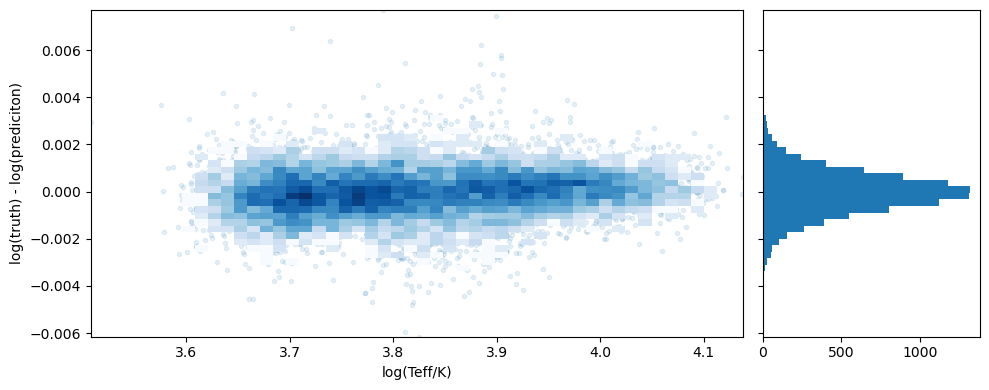

In [62]:
key = "log_Teff"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
s = ax.scatter(sample[key], log_error.loc[sample.index, key], marker=".", alpha=0.1)
ax.hist2d(sample[key], log_error.loc[sample.index, key], bins=50, range=rlim, cmin=3, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(truth) - log(prediciton)")

ax = axes[1]
ax.hist(log_error.loc[sample.index, key], bins=50, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

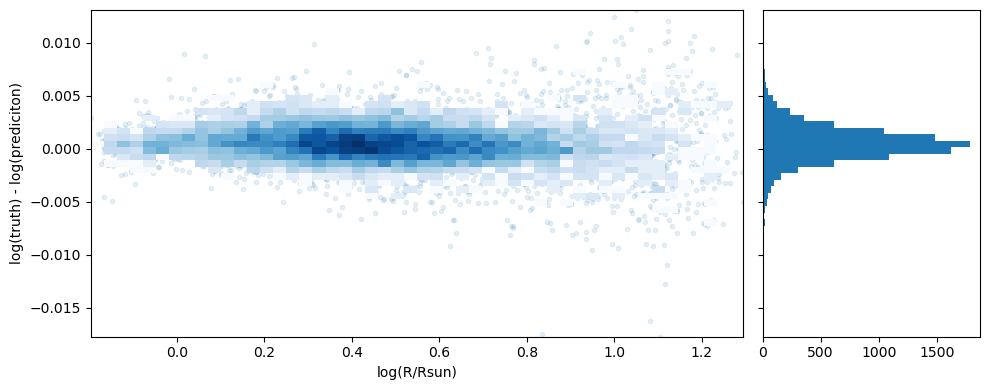

In [63]:
key = "log_radius"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))
ax = axes[0]
s = ax.scatter(sample[key], log_error.loc[sample.index, key], marker=".", alpha=0.1)
ax.hist2d(sample[key], log_error.loc[sample.index, key], bins=50, range=rlim, cmin=3, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel("log(R/Rsun)")
ax.set_ylabel("log(truth) - log(prediciton)")

ax = axes[1]
ax.hist(log_error.loc[sample.index, key], bins=50, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

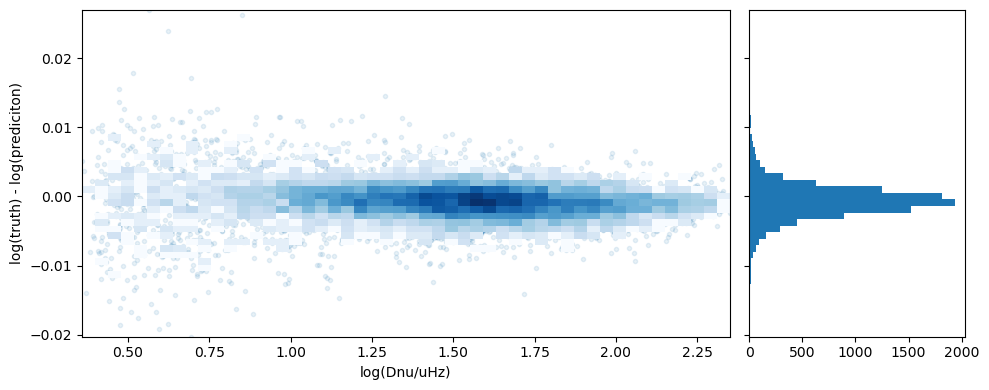

In [64]:
key = "log_Dnu_freq_o"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
s = ax.scatter(sample[key], log_error.loc[sample.index, key], marker=".", alpha=0.1)
ax.hist2d(sample[key], log_error.loc[sample.index, key], bins=50, range=rlim, cmin=3, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel("log(Dnu/uHz)")
ax.set_ylabel("log(truth) - log(prediciton)")

ax = axes[1]
ax.hist(log_error.loc[sample.index, key], bins=50, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

In [12]:
quantiles = [.01, .16, .5, .84, .99]

In [13]:
log_error.quantile(quantiles)

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
0.01,-0.007033,-0.002775,-0.004932,-0.008636
0.16,-0.002775,-0.000921,-0.000949,-0.002751
0.50,-0.001139,-0.000034,0.000451,-0.000671
0.84,0.000797,0.000800,0.001973,0.001238
0.99,0.016639,0.002620,0.005798,0.007102


In [14]:
error.quantile(quantiles)

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
0.01,-3.462402e+08,-43.727432,-0.101409,-0.982495
0.16,-2.131610e+07,-13.381836,-0.006814,-0.263412
0.50,-2.539200e+06,-0.508789,0.002505,-0.038662
0.84,2.271744e+06,13.034180,0.013631,0.071514
0.99,3.527482e+07,45.134170,0.119015,0.505311


## To Do

- How propagates to parallax, luminosity etc.
- Start inference algorithm
    - 1 star
    - N stars
- In parallel train and improve emulator

In [15]:
test_pred["radius"] = 10**test_pred["log_radius"]
test_pred["Teff"] = 10**test_pred["log_Teff"]

test_pred["log_L"] = np.log10(luminosity(test_pred))

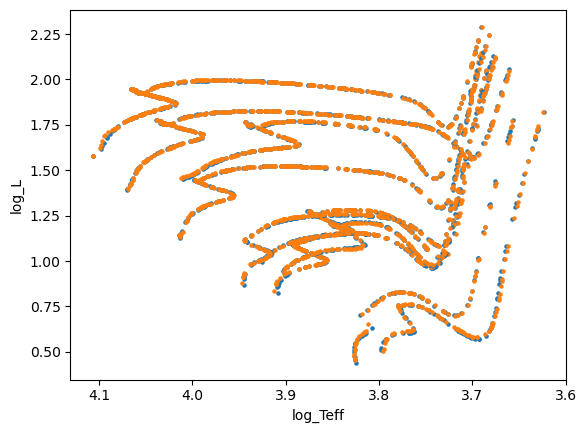

In [16]:
num_tracks = 10
random_state = 0
fig, ax = plt.subplots()
for ti in test.track.sample(num_tracks, random_state=random_state):
    mask = test.track == ti
    ax = test.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = test_pred.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

ax.invert_xaxis();

In [66]:
test_labels

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
7,7.732810,3.804184,-0.046485,2.168433
22,8.887618,3.806648,-0.032545,2.146368
24,8.938270,3.807014,-0.030930,2.143763
25,8.966047,3.807235,-0.029954,2.142189
30,9.073712,3.808238,-0.025440,2.134920
...,...,...,...,...
6587227,10.160006,3.626288,1.041575,0.551837
6587229,10.160075,3.625003,1.054021,0.533074
6587232,10.160152,3.623497,1.068858,0.510747
6587233,10.160203,3.622522,1.078239,0.496672
